In [1]:
pip install pyts --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import resample

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import *
#ZeroPadding3D
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from pyts.image import RecurrencePlot
import shutil

import warnings
#suppress warnings like RunTime error
warnings.filterwarnings('ignore')

shutil.rmtree('C:\\Users\\jagat\\Downloads\\weights', ignore_errors=True)
shutil.rmtree('C:\\Users\\jagat\\Downloads\\logs', ignore_errors=True)
%matplotlib inline

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7313239869262404320
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10266982675512926210
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
#main_path = '/content/drive/MyDrive/TeamIndia/Dataset/UTD-MHAD/Inertial/Inertial/'
main_path = 'C:\\Users\\jagat\\Desktop\\Masters\\Team Project\\UTD\\Inertial/'
data_inertial_lists=os.listdir(main_path)

In [6]:
data_inertial_lists[-3]

'a9_s8_t2_inertial.mat'

In [7]:
random_name = data_inertial_lists[8]
random_test = sio.loadmat(main_path+random_name)
random_test_name = random_name.split('/')[-1].split('.')[0]
random_test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 02 14:01:12 2015',
 '__version__': '1.0',
 '__globals__': [],
 'd_iner': array([[-0.987549, -0.155762, -0.117188, -0.274809,  2.229008, -0.519084],
        [-0.986084, -0.152588, -0.135254, -0.671756,  2.167939, -0.396947],
        [-0.986328, -0.15332 , -0.136475, -0.854962,  2.442748, -0.274809],
        ...,
        [-0.974365, -0.136475, -0.104004, -3.145038, -0.061069, -3.29771 ],
        [-0.971191, -0.110596, -0.118896, -2.198473, -1.282443, -2.015267],
        [-0.979492, -0.102051, -0.151123, -0.885496, -1.862595, -0.427481]])}

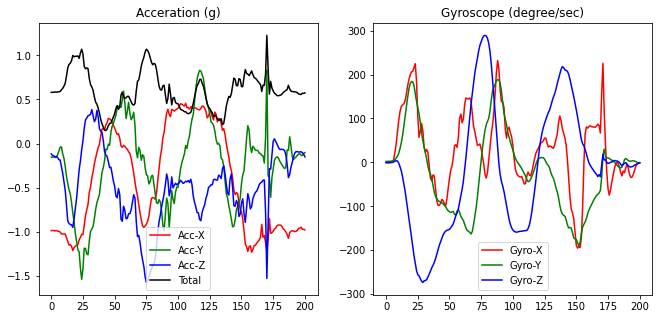

In [8]:
inertial_info = random_test['d_iner']
acc_x = inertial_info[:,0]
acc_y = inertial_info[:,1]
acc_z = inertial_info[:,2]
tot= np.sqrt((acc_x**2 + acc_y**2 + acc_z**2)/3)

gyro_x = inertial_info[:,3]
gyro_y = inertial_info[:,4]
gyro_z = inertial_info[:,5]

%matplotlib inline
fig, ax = plt.subplots(1,2, sharex=True, figsize = (11,5))
a, = ax[0].plot(acc_x, c = 'r')
a_2,= ax[0].plot(acc_y, c = 'g')
a_3, = ax[0].plot(acc_z, c = 'b')
a_4, = ax[0].plot(tot, c = 'black')

ax[0].set_title('Acceration (g)')
ax[0].legend([a,a_2,a_3,a_4], ['Acc-X', 'Acc-Y', 'Acc-Z', 'Total'])

g, = ax[1].plot(gyro_x, c = 'r')
g_2, = ax[1].plot(gyro_y, c = 'g')
g_3, = ax[1].plot(gyro_z, c = 'b')
ax[1].set_title('Gyroscope (degree/sec)')

ax[1].legend([g,g_2,g_3], ['Gyro-X', 'Gyro-Y', 'Gyro-Z'])


plt.show()

## Master controls

In [9]:
resample_= True
resample_len= 128
overlap_per= 0
windows = 128 #  resample_len

In [10]:
class_labels = ['swipe left','swipe right','wave','clap','throw','arm cross','basketball shoot','draw x','draw circle CW'
                ,'draw circle CCW','draw triangle','bowling','boxing','baseball swing','tennis swing','arm curl'
                ,'tennis serve','push','knock','catch','pickup throw']

def find_action_number(path):
    return int(path.split('/')[-1].split('_')[0][1:])

def get_subject_number(path):
    return int(path.split('/')[-1].split('_')[1][1:])

In [11]:
def get_paths(tr_subj,te_subj):
    train_list = []
    test_list = []

    for path in data_inertial_lists:
        if get_subject_number(path) in tr_subj:
            train_list.append(path)
        else:
            test_list.append(path)
    return train_list,test_list

In [12]:
def extract_sliding_windows(df_data, windows, steps, label):
    num_features = 6
    window_segments = []
    label_segments = []

    for i in range(0, (df_data.shape[0])-windows, steps):
        acc_x = df_data[:,0][i: i+windows]
        acc_y = df_data[:,1][i: i+windows]
        acc_z = df_data[:,2][i: i+windows]
        gyro_x = df_data[:,3][i: i+windows]
        gyro_y = df_data[:,4][i: i+windows]
        gyro_z = df_data[:,5][i: i+windows]
        #_label = df_data['label'][i: i+windows]
        #label = Counter(_label).most_common()[0][0]
        window_segments.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
        label_segments.append(label)

    window_segments_reshape = np.asarray(window_segments, dtype= np.float32).transpose(0,2,1)#.reshape(-1, windows, num_features)
    label_segments = np.asarray(label_segments)

    return window_segments_reshape, label_segments

def calc_tot_acc(X):
    p,q,r=X.shape
    X_new=np.zeros(shape=(p,q,r+1))
    X_new[:,:,:-1]=X
    for i in range(X.shape[0]):
        X_new[i,:,6]= np.sqrt((X[i,:,0]**2 + X[i,:,1]**2 + X[i,:,2]**2)/3)
    return X_new

In [13]:
def get_data(path_list):
    actvs=['None']*21
    for i in range(len(class_labels)):
        actvs[i]=[]
        for path in path_list:
            if find_action_number(path)==i+1:
                actvs[i].append(path)
                
    new_X_=['None']*21
    for i in range(len(actvs)):
        new_X_[i]=[]
        for path in actvs[i]:
            if resample_: caps= resample(sio.loadmat(main_path+path)['d_iner'], resample_len)
            else: caps= sio.loadmat(main_path + path)['d_iner']
            new_X_[i].append(caps)
        #new_X_[i]= np.array(new_X_[i],dtype=object)
    new_X_=np.array(new_X_,dtype=object)
    
    XPn=[]
    for i in range(len(new_X_)):
        #XPn[i]=[]
        a=new_X_[i][0]
        for j in range(len(new_X_[i])-1):
            b=new_X_[i][j+1]
            vast= np.vstack((a,b))
            a = vast
        XPn.append(np.array(vast, dtype=object))
    XPn=np.array(XPn, dtype=object)
    
    
    steps = int(windows*(1-(overlap_per/100))) 
    window_segments_reshape, label_segments = [], [] 
    X_fin,y_fin= extract_sliding_windows(XPn[0], windows, steps, 1)

    for i in range(len(XPn)-1):
        b= extract_sliding_windows(XPn[i+1], windows, steps, i+2)
        X_s= np.concatenate((X_fin, b[0]))
        y_s= np.concatenate((y_fin, b[1]))
        X_fin= X_s
        y_fin= y_s
    
    y_tr = to_categorical(y_fin)
    final_Y = np.delete(y_tr,0,1)
    #final_Y.shape
    np.random.seed(42)
    rand_indices= np.random.permutation(X_fin.shape[0])
    X_fin= X_fin[rand_indices]
    final_Y= final_Y[rand_indices]
    X_fin= calc_tot_acc(X_fin)
    return X_fin,final_Y

In [14]:
X_train=np.zeros(shape=(1,128,7))
np.random.seed(0) 
model_simple_CNN = models.Sequential(name = 'CNN_simple') 

#model_simple_CNN.build(input_shape=(x2, x3, 1))
#model_simple_CNN.add(layers.ZeroPadding2D(padding=(2, 2)))
model_simple_CNN.add(Conv2D(32,(5, 5), activation='selu', input_shape=(int(X_train.shape[1]/4), X_train.shape[2]*4, 1)))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(MaxPooling2D((2,2)))
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(64,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(16,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.Flatten())
#model_simple_CNN.add(layers.Dense(3072, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(1536, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(21, activation='softmax'))

weights_simple_CNN= model_simple_CNN.get_weights()


model_simple_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_simple_CNN.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

In [15]:

np.random.seed(0)
model_LSTM = Sequential(name = 'LSTM')
model_LSTM.add(CuDNNLSTM(512, input_shape=(None, X_train.shape[2]))) 
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(21, activation='softmax'))

weights_LSTM= model_LSTM.get_weights()

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=3e-4), metrics=['accuracy'])

#print(model_LSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_LSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)



In [16]:
np.random.seed(0)
model_biLSTM = Sequential(name = 'bidirectional_LSTM')
model_biLSTM.add(Bidirectional(CuDNNLSTM(512), input_shape=(None, X_train.shape[2])))
model_biLSTM.add(Dense(100, activation='relu'))
model_biLSTM.add(Dropout(0.5))
model_biLSTM.add(BatchNormalization())
model_biLSTM.add(Dense(21, activation='softmax'))

weights_biLSTM= model_biLSTM.get_weights()

model_biLSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=3e-4), metrics=['accuracy'])

#print(model_biLSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_biLSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


In [17]:
np.random.seed(0)
x2,x3,x4=32,32,21
model_all = models.Sequential(name = 'all_images_combined')
model_all.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_all.add(BatchNormalization())
model_all.add(layers.MaxPooling3D((2, 2, 2)))
model_all.add(Dropout(0.5))
#model_all.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_all.add(layers.Conv3D(20, (3, 3, 2), activation='selu'))
model_all.add(Dropout(0.5))
model_all.add(layers.Conv3D(10, (4, 4, 4), activation='selu'))
model_all.add(layers.Flatten())
model_all.add(Dropout(0.5))
#model_all.add(layers.Dense(2100, activation='selu'))
#model_all.add(Dropout(0.5))
model_all.add(layers.Dense(1050, activation='sigmoid'))
model_all.add(layers.Dense(21, activation='softmax'))
#print(model_all.summary())

weights_all= model_all.get_weights()

model_all.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)
shutil.rmtree('weights', ignore_errors=True)
weights_dir = 'weights/' + model_all.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


In [18]:
factor=int(X_train.shape[1]/32)
kk=int(X_train.shape[1]/factor)
transformer1 = MarkovTransitionField(image_size=1/factor,strategy='uniform')
transformer2 = GramianAngularField(image_size=1/factor,method='difference')
transformer3 = RecurrencePlot(threshold=0.02)
avg_filt=layers.AveragePooling2D((factor, factor))

def new_X(X):
    Xp=np.zeros(shape=(X.shape[0],kk,kk,X.shape[2]*3))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img1=transformer1.transform(dt.reshape(1,-1)).reshape(kk,kk)
            #if i<1 and j<1:print(img1.shape)
            Xp[i,:,:,3*j]=img1
            img2=transformer2.transform(dt.reshape(1,-1)).reshape(kk,kk)
            Xp[i,:,:,3*j+1]=img2
            img3=transformer3.transform(dt.reshape(1,-1))
            img3=avg_filt(img3.reshape(1,int(X_train.shape[1]),int(X_train.shape[1]),1)).reshape(kk,kk)
            Xp[i,:,:,3*j+2]=img3
    return Xp



In [19]:

def reset_params(model,weights):
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\weights', ignore_errors=True)
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\logs', ignore_errors=True)
    model.set_weights(weights)

def calc_scores(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    return train_acc[-1]*100,val_acc[-1]*100

def normalise_data(X_train,X_test):
    for i in range(X_train.shape[2]):
        maxi=np.amax(X_train[:,:,i])
        mini=np.amin(X_train[:,:,i])
    
        X_train[:,:,i]= (X_train[:,:,i]-mini)/(maxi-mini)
        X_test[:,:,i]= (X_test[:,:,i]-mini)/(maxi-mini)
    return X_train,X_test
    
models_all=[ model_simple_CNN, model_LSTM, model_biLSTM, model_all ]

weights={ model_simple_CNN: weights_simple_CNN, model_LSTM: weights_LSTM, 
         model_biLSTM: weights_biLSTM, model_all:weights_all }

In [20]:
tr_sub=[1,3,5,7]
te_sub=[2,4,6,8]
tr_list,te_list= get_paths(tr_sub,te_sub)
X_train,Y_train= get_data(tr_list)
X_test,Y_test= get_data(te_list)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((314, 128, 7), (315, 128, 7), (314, 21), (315, 21))

In [21]:
# normalise data
for i in range(X_train.shape[2]):
    mean=np.mean(X_train[:,:,i])
    std=np.std(X_train[:,:,i])
    
    X_train[:,:,i]= (X_train[:,:,i]-mean)/(std)
    X_test[:,:,i]= (X_test[:,:,i]-mean)/(std)

In [22]:
numb=20
def get_label(Y):
    return np.array(class_labels)[np.argmax(Y, axis = -1)]

lbt_te=get_label(Y_test)
lbt_tr=get_label(Y_train)
c_0_te=[i for i, j in enumerate(list(lbt_te)) if j == class_labels[numb]][0:5]
c_0_tr=[i for i, j in enumerate(list(lbt_tr)) if j == class_labels[numb]][0:5]

pickup throw


<Figure size 432x288 with 0 Axes>

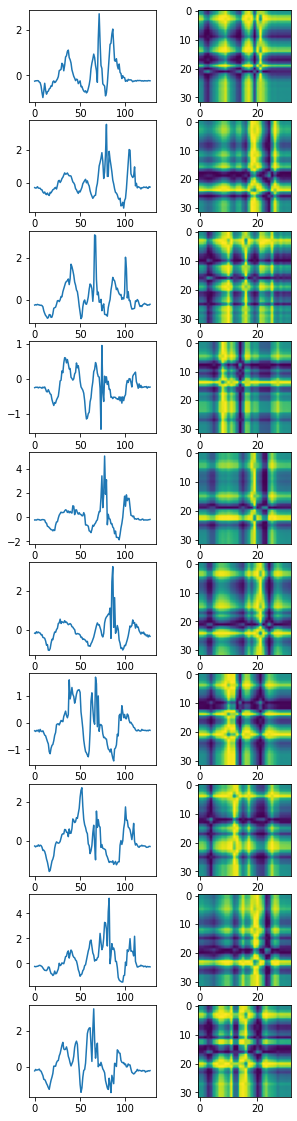

In [23]:
axis_=6
j=0
plt.figure()
print(lbt_tr[c_0_tr[0]])
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(10,2) 

f.set_figheight(20)
f.set_figwidth(5)
for i in c_0_te:
    acv=X_test[i,:,axis_]
    axarr[j,0].plot(acv);
    p=transformer2.transform(acv.reshape(1,-1))
    axarr[j,1].imshow(p.reshape(kk,kk));
    j+=1
for i in c_0_tr:
    acer=X_train[i,:,axis_]
    axarr[j,0].plot(acer);
    p=transformer2.transform(acer.reshape(1,-1))
    axarr[j,1].imshow(p.reshape(kk,kk));
    j+=1
plt.show();

In [24]:
def plot_graphs(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy") 
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.show()

    train_acc = history.history['loss']
    val_acc = history.history['val_loss']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\weights', ignore_errors=True)
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\logs', ignore_errors=True)
    
def calc_scores(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    return train_acc[-1]*100,val_acc[-1]*100

scores=np.zeros(shape=(8,2))

In [25]:
def conf_mat(X,Y,model_name):
    pred = np.argmax(model_name.predict(X), axis = -1)
    confusion = confusion_matrix(np.argmax(Y, axis = -1), pred)
    NUM_LABELS = Y.shape[1]
    f, axes = plt.subplots(1,1, figsize = (12,12))
    axes.set_xlabel('Actual')
    axes.set_ylabel('Predicted')
    axes.grid(False)
    axes.set_xticklabels(class_labels, rotation = 90)
    axes.set_yticklabels(class_labels)
    axes.set_yticks(list(range(NUM_LABELS)))
    axes.set_xticks(list(range(NUM_LABELS)))
    plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')
    
    
    print('\nClassification Report\n')
    print(classification_report(np.argmax(Y, axis = -1), pred, 
                                target_names=class_labels))
    print('\nConfusion Matrix\n')
    for i, cas in enumerate(confusion):
        for j, count in enumerate(cas):
            if count > 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

In [26]:
X_train_base= X_train.reshape(-1,int(X_train.shape[1]/4),28) #(-1,X_train.shape[1]*X_train.shape[2])
X_test_base= X_test.reshape(-1,int(X_train.shape[1]/4),28) #reshape(-1,X_test.shape[1]*X_test.shape[2])
x1,x2,x3= X_train_base.shape
x1,x2,x3

(314, 32, 28)

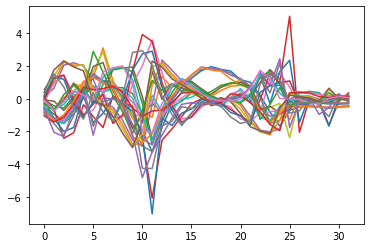

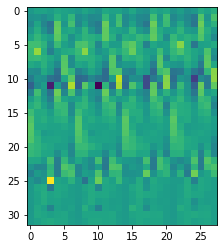

In [27]:
plt.plot(X_train_base[0]);
plt.show()
plt.imshow(X_train_base[0]);

Epoch 1/15
10/10 [==============================] - 6s 101ms/step - loss: 5.7516 - accuracy: 0.0414 - val_loss: 2.5958 - val_accuracy: 0.2095
Epoch 2/15
10/10 [==============================] - 1s 127ms/step - loss: 4.8972 - accuracy: 0.0924 - val_loss: 2.0553 - val_accuracy: 0.4698
Epoch 3/15
10/10 [==============================] - 0s 22ms/step - loss: 4.2971 - accuracy: 0.1369 - val_loss: 1.6550 - val_accuracy: 0.5587
Epoch 4/15
10/10 [==============================] - 2s 263ms/step - loss: 3.4179 - accuracy: 0.2229 - val_loss: 1.3628 - val_accuracy: 0.6444
Epoch 5/15
10/10 [==============================] - 2s 208ms/step - loss: 2.9671 - accuracy: 0.3089 - val_loss: 1.1859 - val_accuracy: 0.6476
Epoch 6/15
10/10 [==============================] - 1s 44ms/step - loss: 2.3898 - accuracy: 0.4331 - val_loss: 1.1618 - val_accuracy: 0.6381
Epoch 7/15
10/10 [==============================] - 0s 23ms/step - loss: 2.0670 - accuracy: 0.4809 - val_loss: 1.1970 - val_accuracy: 0.6190
Epoch 8/1

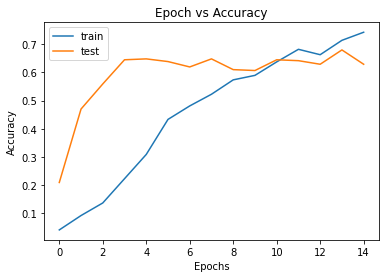

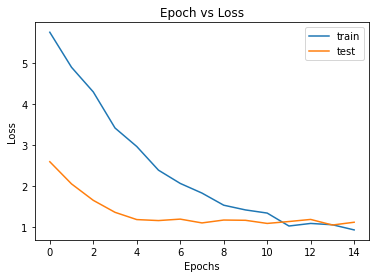


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.58      1.00      0.73        15
     swipe right       0.72      0.87      0.79        15
            wave       0.73      0.53      0.62        15
            clap       0.50      0.27      0.35        15
           throw       0.69      0.60      0.64        15
       arm cross       0.36      1.00      0.53        15
basketball shoot       1.00      0.53      0.70        15
          draw x       1.00      0.47      0.64        15
  draw circle CW       0.45      0.67      0.54        15
 draw circle CCW       0.62      0.53      0.57        15
   draw triangle       1.00      0.67      0.80        15
         bowling       0.79      1.00      0.88        15
          boxing       0.60      0.20      0.30        15
  baseball swing       0.79      0.73      0.76        15
    tennis swing       1.00      0.47      0.64        15
        arm curl       0.64      0.60      0.62

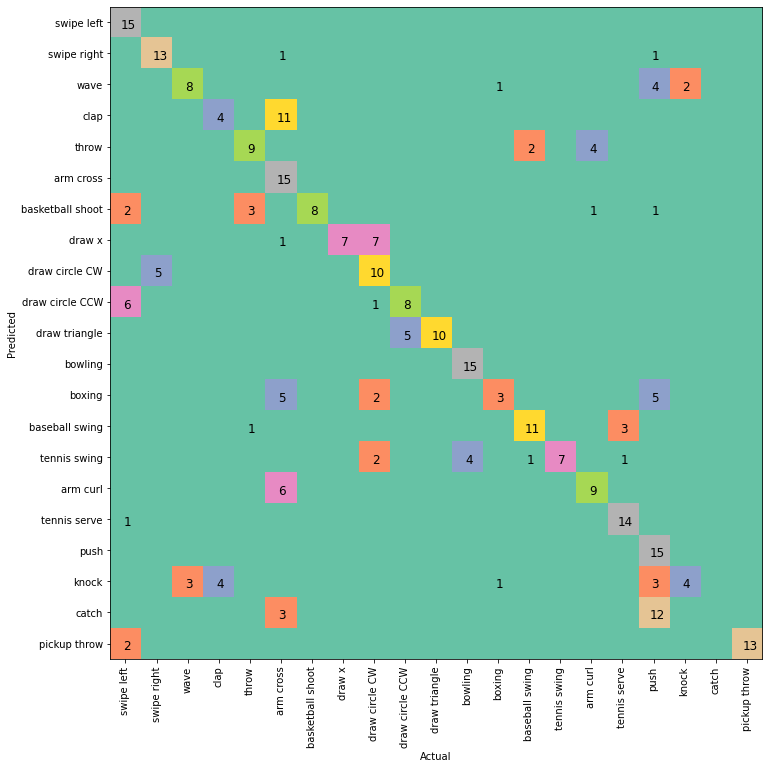

In [28]:
reset_params(model_simple_CNN,weights_simple_CNN)

history = model_simple_CNN.fit(X_train_base, Y_train , epochs=15, batch_size=32,
                    validation_data=(X_test_base, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[0,:]=calc_scores(history)
conf_mat(X_test_base, Y_test, model_simple_CNN)

Epoch 1/50
10/10 [==============================] - 4s 129ms/step - loss: 3.1308 - accuracy: 0.0637 - val_loss: 3.0430 - val_accuracy: 0.0508
Epoch 2/50
10/10 [==============================] - 1s 62ms/step - loss: 3.0480 - accuracy: 0.0924 - val_loss: 3.0365 - val_accuracy: 0.0540
Epoch 3/50
10/10 [==============================] - 1s 61ms/step - loss: 2.9677 - accuracy: 0.0764 - val_loss: 3.0120 - val_accuracy: 0.0984
Epoch 4/50
10/10 [==============================] - 1s 60ms/step - loss: 2.8637 - accuracy: 0.1115 - val_loss: 2.9980 - val_accuracy: 0.1206
Epoch 5/50
10/10 [==============================] - 1s 64ms/step - loss: 2.7844 - accuracy: 0.1433 - val_loss: 2.9534 - val_accuracy: 0.1714
Epoch 6/50
10/10 [==============================] - 1s 64ms/step - loss: 2.6520 - accuracy: 0.1815 - val_loss: 2.9572 - val_accuracy: 0.1524
Epoch 7/50
10/10 [==============================] - 1s 63ms/step - loss: 2.7286 - accuracy: 0.1529 - val_loss: 2.9120 - val_accuracy: 0.1333
Epoch 8/50
1

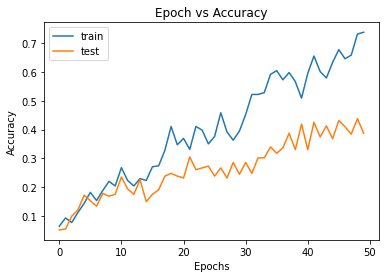

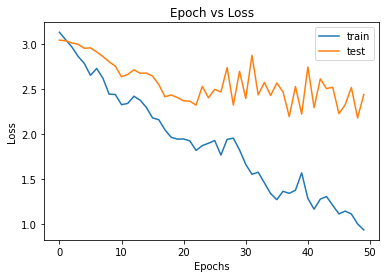


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.11      0.07      0.08        15
     swipe right       0.18      0.13      0.15        15
            wave       1.00      0.27      0.42        15
            clap       0.28      0.33      0.30        15
           throw       0.00      0.00      0.00        15
       arm cross       0.39      0.60      0.47        15
basketball shoot       0.00      0.00      0.00        15
          draw x       0.30      0.67      0.42        15
  draw circle CW       0.27      0.27      0.27        15
 draw circle CCW       0.38      0.33      0.36        15
   draw triangle       0.71      0.33      0.45        15
         bowling       0.91      0.67      0.77        15
          boxing       0.25      0.27      0.26        15
  baseball swing       0.54      1.00      0.70        15
    tennis swing       0.31      0.53      0.39        15
        arm curl       0.88      0.47      0.61

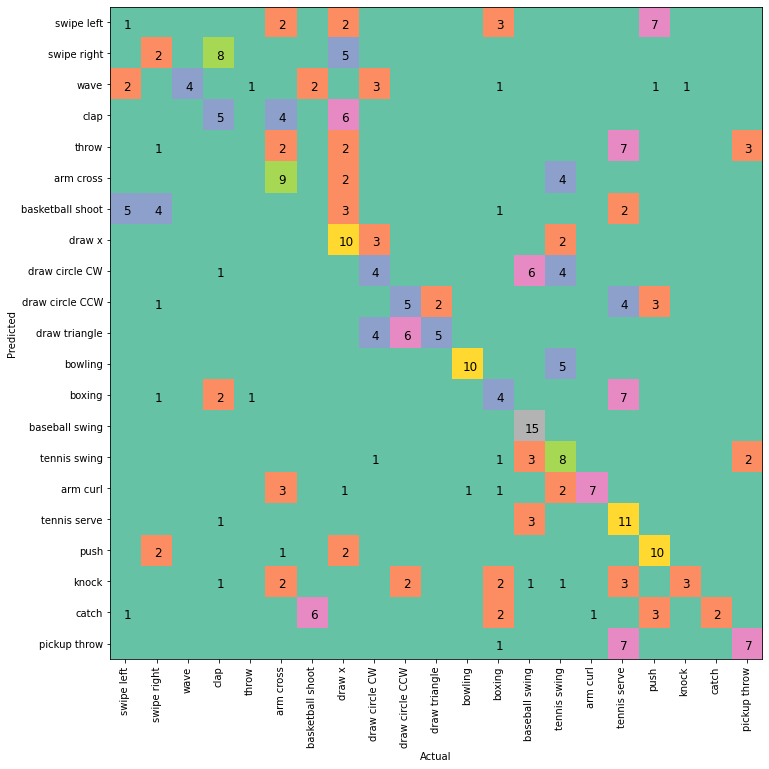

In [29]:
reset_params(model_LSTM,weights_LSTM)
history = model_LSTM.fit(X_train, Y_train , epochs=50, batch_size=32,
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[1,:]=calc_scores(history)
conf_mat(X_test, Y_test, model_LSTM)

Epoch 1/50
10/10 [==============================] - 4s 176ms/step - loss: 3.0771 - accuracy: 0.0924 - val_loss: 3.0086 - val_accuracy: 0.0635
Epoch 2/50
10/10 [==============================] - 1s 105ms/step - loss: 2.7005 - accuracy: 0.1688 - val_loss: 2.9696 - val_accuracy: 0.1651
Epoch 3/50
10/10 [==============================] - 1s 105ms/step - loss: 2.4446 - accuracy: 0.2293 - val_loss: 2.9047 - val_accuracy: 0.2698
Epoch 4/50
10/10 [==============================] - 1s 106ms/step - loss: 2.1841 - accuracy: 0.3248 - val_loss: 2.8015 - val_accuracy: 0.3397
Epoch 5/50
10/10 [==============================] - 1s 106ms/step - loss: 1.9577 - accuracy: 0.3726 - val_loss: 2.7228 - val_accuracy: 0.3714
Epoch 6/50
10/10 [==============================] - 1s 104ms/step - loss: 1.8922 - accuracy: 0.4045 - val_loss: 2.6164 - val_accuracy: 0.4095
Epoch 7/50
10/10 [==============================] - 1s 104ms/step - loss: 1.7256 - accuracy: 0.4809 - val_loss: 2.5222 - val_accuracy: 0.4095
Epoch 

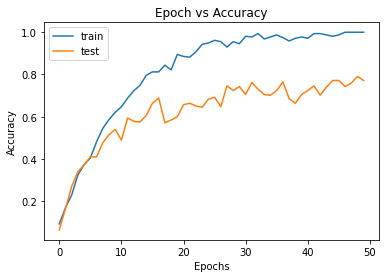

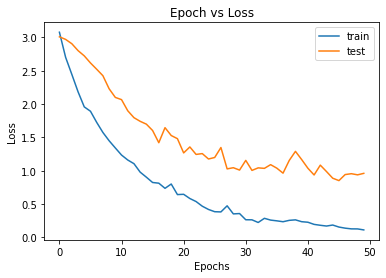


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.78      0.93      0.85        15
     swipe right       0.79      0.73      0.76        15
            wave       1.00      0.40      0.57        15
            clap       0.75      1.00      0.86        15
           throw       0.71      0.67      0.69        15
       arm cross       1.00      1.00      1.00        15
basketball shoot       1.00      1.00      1.00        15
          draw x       0.82      0.93      0.87        15
  draw circle CW       0.70      0.93      0.80        15
 draw circle CCW       0.56      0.60      0.58        15
   draw triangle       0.60      0.40      0.48        15
         bowling       0.93      0.93      0.93        15
          boxing       0.88      1.00      0.94        15
  baseball swing       0.67      0.67      0.67        15
    tennis swing       0.69      0.73      0.71        15
        arm curl       1.00      1.00      1.00

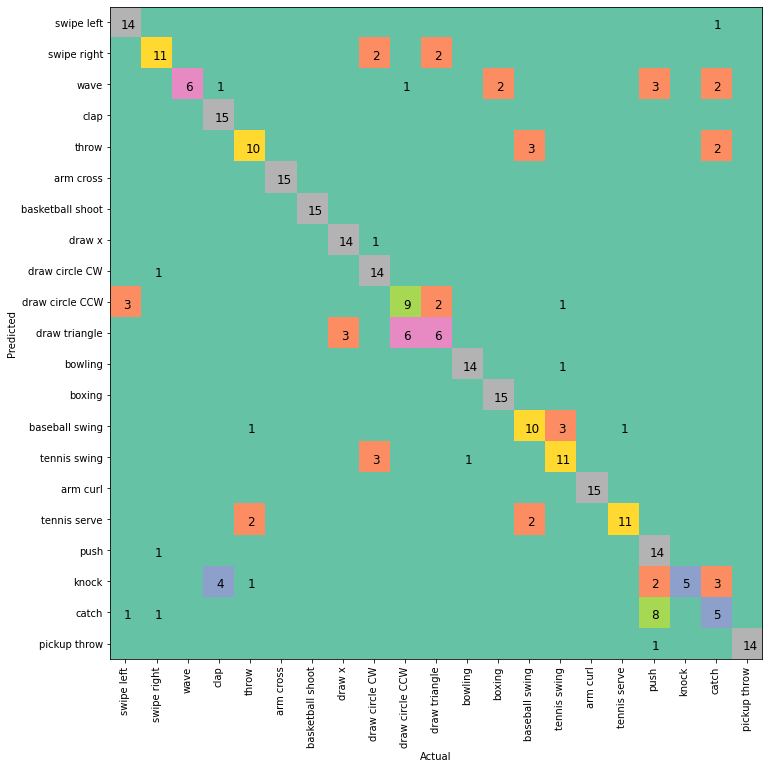

In [30]:
reset_params(model_biLSTM,weights_biLSTM)
history = model_biLSTM.fit(X_train, Y_train , epochs=50, batch_size=32,
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[2,:]=calc_scores(history)
conf_mat(X_test, Y_test, model_biLSTM)

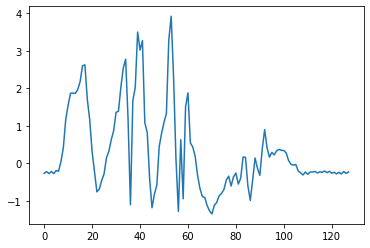

(1, 32, 32)


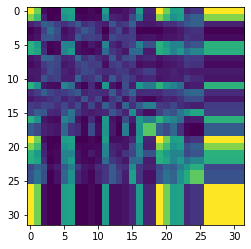

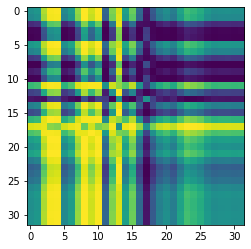

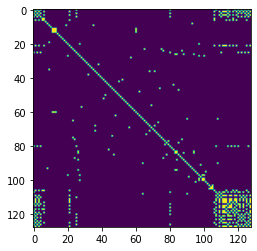

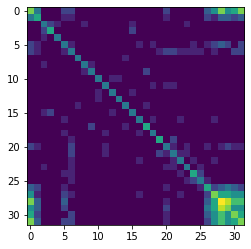

In [31]:
acv=X_train[10,:,6]
plt.plot(acv)
plt.show()
factor=int(X_train.shape[1]/32)
k=int(len(acv)/factor)
transformer1 = MarkovTransitionField(image_size=1/factor,strategy='uniform', overlapping=True)
transformer2 = GramianAngularField(image_size=1/factor,method='difference',overlapping=True)
transformer3 = RecurrencePlot(threshold=0.02)
transformer4 = RecurrencePlot(threshold=10)
p=transformer1.transform(acv.reshape(1,-1))
q=transformer2.transform(acv.reshape(1,-1))
r=transformer3.transform(acv.reshape(1,-1))
print(p.shape)
plt.imshow(p.reshape(k,k));
plt.show()
plt.imshow(q.reshape(k,k));
plt.show()
plt.imshow(r.reshape(factor*k,factor*k));
plt.show()
avg_filt=layers.AveragePooling2D((factor, factor))
plt.imshow(avg_filt(r.reshape(1,len(acv),len(acv),1)).reshape(k,k));

In [32]:
def new_X_MTF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_MTF_train=new_X_MTF(X_train)
X_MTF_test=new_X_MTF(X_test)
x1,x2,x3,x4= X_MTF_train.shape
print(x1,x2,x3,x4)

314 32 32 7


Model: "Only_MTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 28, 28, 6, 10)     510       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 14, 14, 6, 10)    0         
 3D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 6, 10)     0         
                                                                 
 zero_padding3d (ZeroPadding  (None, 18, 18, 8, 10)    0         
 3D)                                                             
                                                          

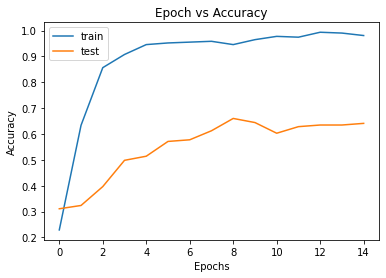

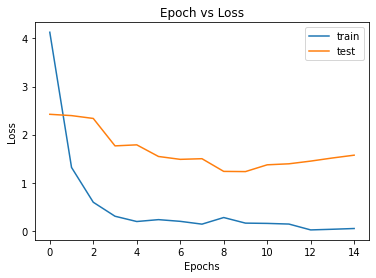


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.80      0.80      0.80        15
     swipe right       1.00      0.60      0.75        15
            wave       0.81      0.87      0.84        15
            clap       0.79      1.00      0.88        15
           throw       0.39      0.47      0.42        15
       arm cross       0.93      0.87      0.90        15
basketball shoot       0.19      0.40      0.26        15
          draw x       0.60      0.80      0.69        15
  draw circle CW       0.48      0.80      0.60        15
 draw circle CCW       0.67      0.40      0.50        15
   draw triangle       0.91      0.67      0.77        15
         bowling       0.67      0.67      0.67        15
          boxing       0.46      0.40      0.43        15
  baseball swing       0.86      0.40      0.55        15
    tennis swing       0.69      0.73      0.71        15
        arm curl       0.77      0.67      0.71

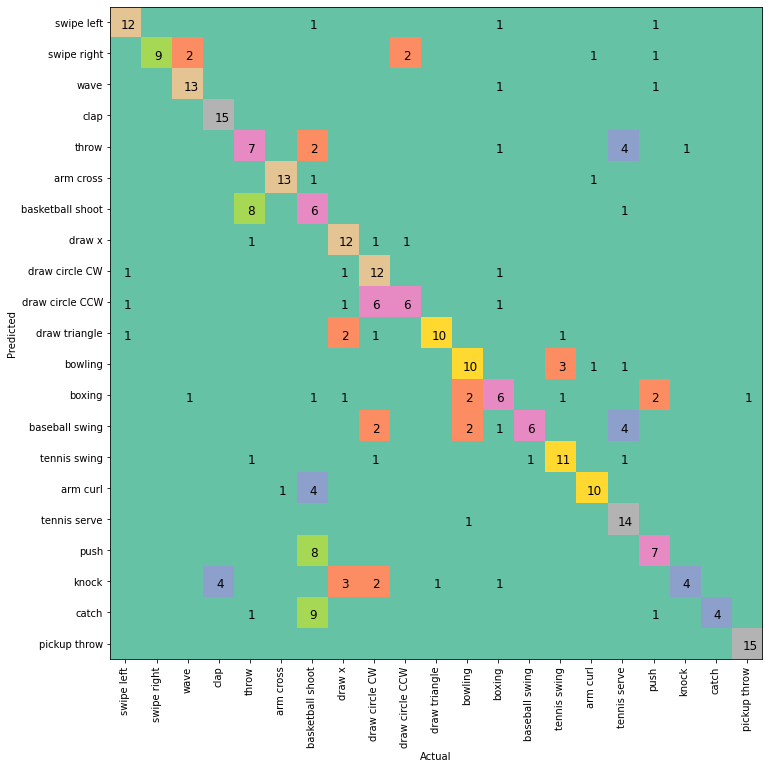

In [33]:
np.random.seed(0)

model_MTF = models.Sequential(name = 'Only_MTF')
model_MTF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_MTF.add(BatchNormalization())
model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_MTF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_MTF.add(layers.Flatten())
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(1000, activation='relu'))
#model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(21, activation='softmax'))
print(model_MTF.summary())

model_MTF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_MTF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_MTF.fit(X_MTF_train, Y_train , epochs=15,
                    batch_size=32, validation_data=(X_MTF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[3,:]=calc_scores(history)
conf_mat(X_MTF_test, Y_test, model_MTF)

In [34]:
def new_X_GAF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_GAF_train=new_X_GAF(X_train)
X_GAF_test=new_X_GAF(X_test)
x1,x2,x3,x4= X_GAF_train.shape
print(x1,x2,x3,x4)

314 32 32 7


Model: "Only_GAF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 28, 28, 6, 10)     510       
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 14, 6, 10)    0         
 3D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 14, 14, 6, 10)     0         
                                                                 
 zero_padding3d_1 (ZeroPaddi  (None, 18, 18, 8, 10)    0         
 ng3D)                                                           
                                                          

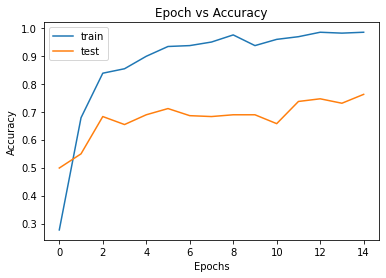

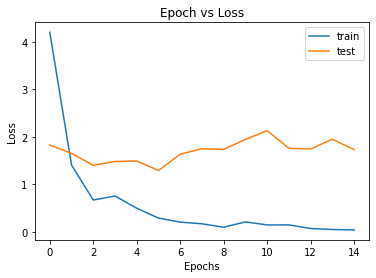


Classification Report

                  precision    recall  f1-score   support

      swipe left       1.00      1.00      1.00        15
     swipe right       0.83      1.00      0.91        15
            wave       0.75      0.40      0.52        15
            clap       0.52      0.93      0.67        15
           throw       0.61      0.73      0.67        15
       arm cross       0.93      0.93      0.93        15
basketball shoot       0.62      0.67      0.65        15
          draw x       0.67      0.80      0.73        15
  draw circle CW       0.58      0.47      0.52        15
 draw circle CCW       1.00      0.53      0.70        15
   draw triangle       1.00      0.87      0.93        15
         bowling       0.87      0.87      0.87        15
          boxing       0.85      0.73      0.79        15
  baseball swing       0.64      0.93      0.76        15
    tennis swing       1.00      0.53      0.70        15
        arm curl       0.93      0.93      0.93

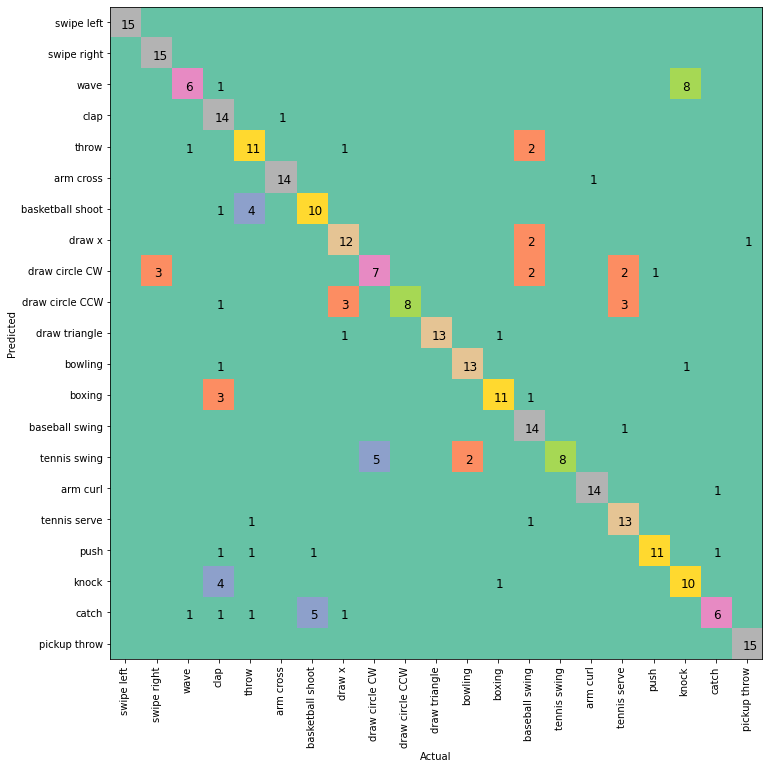

In [35]:
np.random.seed(0)
x1,x2,x3,x4= X_GAF_train.shape

model_GAF = models.Sequential(name = 'Only_GAF')
model_GAF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_GAF.add(BatchNormalization())
model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_GAF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_GAF.add(layers.Flatten())
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(1000, activation='relu'))
#model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(21, activation='softmax'))
print(model_GAF.summary())

model_GAF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_GAF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_GAF.fit(X_GAF_train, Y_train , epochs=15, 
                    batch_size=32, validation_data=(X_GAF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[4,:]=calc_scores(history)
conf_mat(X_GAF_test, Y_test, model_GAF)

In [36]:
def new_X_RP(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer3.transform(dt.reshape(1,-1))
            img=avg_filt(img.reshape(1,len(acv),len(acv),1)).reshape(k,k)
            Xp[i,:,:,j]=img
    return Xp

X_RP_train=new_X_RP(X_train)
X_RP_test=new_X_RP(X_test)
x1,x2,x3,x4= X_RP_train.shape
print(x1,x2,x3,x4)

314 32 32 7


Model: "Only_RP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 28, 28, 6, 10)     510       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 14, 14, 6, 10)    0         
 3D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 6, 10)     0         
                                                                 
 zero_padding3d_2 (ZeroPaddi  (None, 18, 18, 8, 10)    0         
 ng3D)                                                           
                                                           

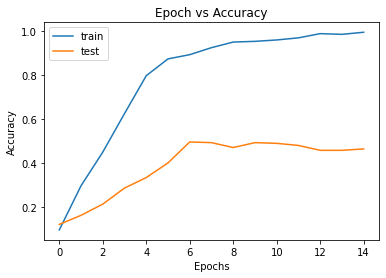

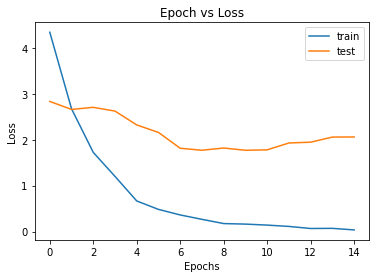


Classification Report

                  precision    recall  f1-score   support

      swipe left       1.00      0.27      0.42        15
     swipe right       1.00      0.27      0.42        15
            wave       0.29      1.00      0.45        15
            clap       0.92      0.80      0.86        15
           throw       0.28      0.80      0.41        15
       arm cross       1.00      0.27      0.42        15
basketball shoot       0.03      0.07      0.04        15
          draw x       0.67      0.53      0.59        15
  draw circle CW       0.00      0.00      0.00        15
 draw circle CCW       0.64      0.47      0.54        15
   draw triangle       0.45      0.60      0.51        15
         bowling       1.00      0.53      0.70        15
          boxing       0.24      0.27      0.25        15
  baseball swing       0.50      0.47      0.48        15
    tennis swing       0.50      0.67      0.57        15
        arm curl       0.75      0.40      0.52

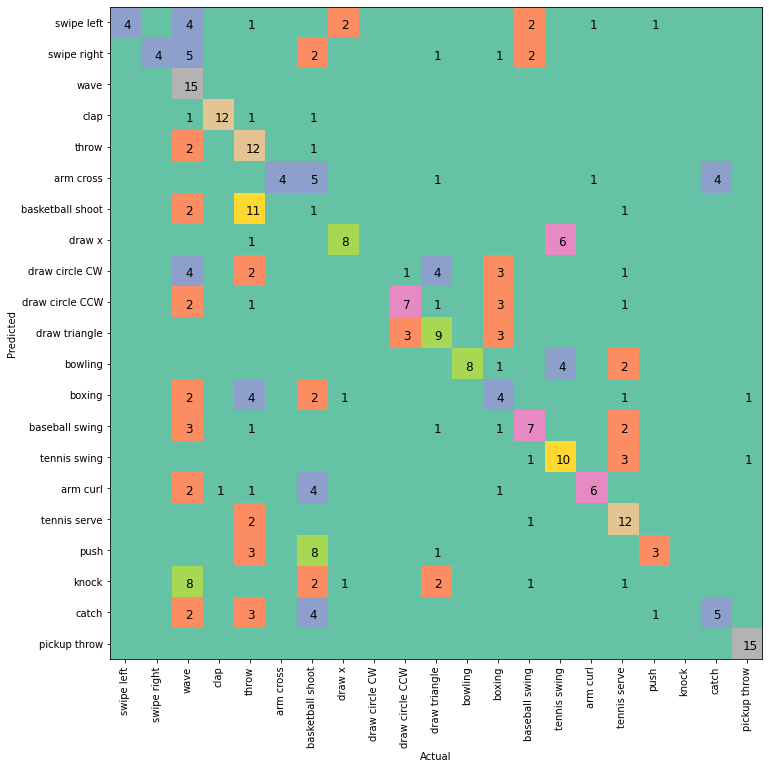

In [37]:
np.random.seed(0)

model_RP = models.Sequential(name ='Only_RP')
model_RP.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_RP.add(BatchNormalization())
model_RP.add(layers.MaxPooling3D((2, 2, 1)))
model_RP.add(Dropout(0.5))
model_RP.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_RP.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_RP.add(Dropout(0.5))
model_RP.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_RP.add(layers.Flatten())
model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(1000, activation='tanh'))
#model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(21, activation='softmax'))
print(model_RP.summary())


model_RP.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_RP.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_RP.fit(X_RP_train, Y_train , epochs=15, 
                    batch_size=32, validation_data=(X_RP_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[5,:]=calc_scores(history)
conf_mat(X_RP_test, Y_test, model_RP)

In [38]:
X_all_img_train=np.concatenate((X_GAF_train,X_MTF_train,X_RP_train),axis=3)
X_all_img_test=np.concatenate((X_GAF_test,X_MTF_test,X_RP_test),axis=3)

x1,x2,x3,x4= X_all_img_train.shape
print(x1,x2,x3,x4)

314 32 32 21


Epoch 1/15
10/10 [==============================] - 2s 92ms/step - loss: 3.0163 - accuracy: 0.1146 - val_loss: 2.3716 - val_accuracy: 0.3746
Epoch 2/15
10/10 [==============================] - 0s 43ms/step - loss: 1.6758 - accuracy: 0.4777 - val_loss: 1.5116 - val_accuracy: 0.5841
Epoch 3/15
10/10 [==============================] - 0s 42ms/step - loss: 0.7938 - accuracy: 0.7994 - val_loss: 1.2711 - val_accuracy: 0.6127
Epoch 4/15
10/10 [==============================] - 0s 43ms/step - loss: 0.4586 - accuracy: 0.8503 - val_loss: 1.0944 - val_accuracy: 0.7016
Epoch 5/15
10/10 [==============================] - 0s 43ms/step - loss: 0.2818 - accuracy: 0.9363 - val_loss: 1.1252 - val_accuracy: 0.6952
Epoch 6/15
10/10 [==============================] - 0s 43ms/step - loss: 0.2072 - accuracy: 0.9395 - val_loss: 1.0654 - val_accuracy: 0.6857
Epoch 7/15
10/10 [==============================] - 0s 44ms/step - loss: 0.1324 - accuracy: 0.9809 - val_loss: 1.0377 - val_accuracy: 0.6952
Epoch 8/15
10

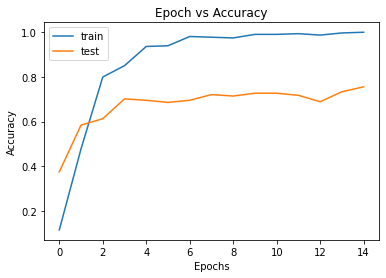

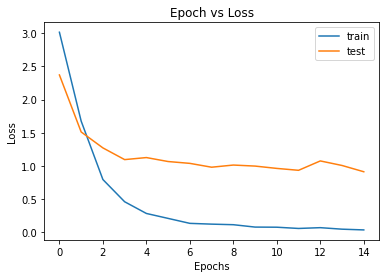


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.93      0.93      0.93        15
     swipe right       0.68      1.00      0.81        15
            wave       0.92      0.73      0.81        15
            clap       0.64      0.93      0.76        15
           throw       0.57      0.27      0.36        15
       arm cross       0.70      0.93      0.80        15
basketball shoot       0.55      0.80      0.65        15
          draw x       0.86      0.80      0.83        15
  draw circle CW       0.62      0.53      0.57        15
 draw circle CCW       1.00      0.53      0.70        15
   draw triangle       0.94      1.00      0.97        15
         bowling       0.93      0.93      0.93        15
          boxing       0.83      0.33      0.48        15
  baseball swing       0.73      0.73      0.73        15
    tennis swing       0.92      0.73      0.81        15
        arm curl       0.77      0.67      0.71

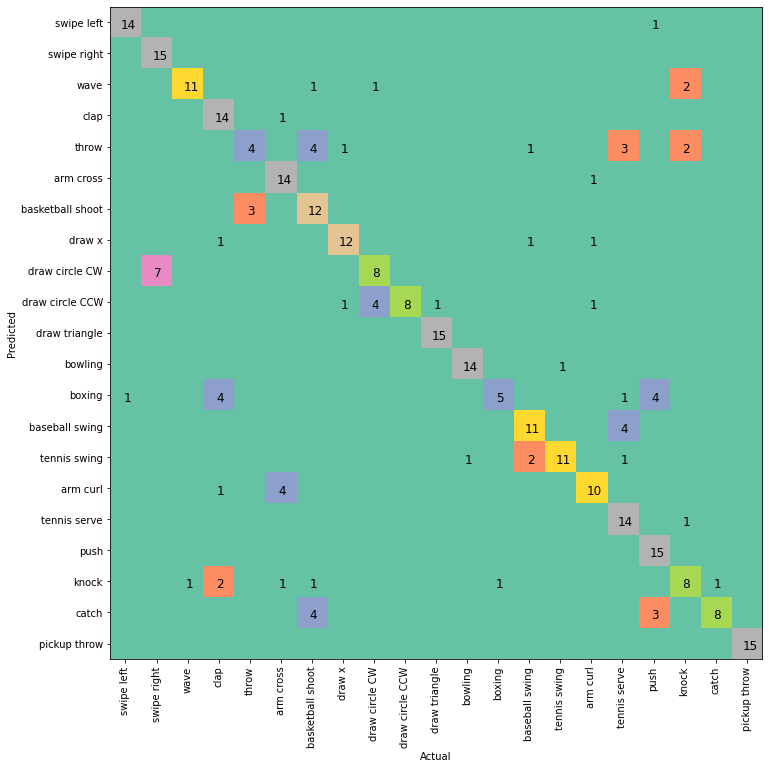

In [39]:
reset_params(model_all,weights_all)

history = model_all.fit(X_all_img_train, Y_train , epochs=15, 
                    batch_size=32, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[6,:]=calc_scores(history)
conf_mat(X_all_img_test, Y_test, model_all)

Model: "CNN_and_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 28, 28, 20, 10)    510       
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 20, 10)   40        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 14, 10, 10)   0         
 3D)                                                             
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 10, 10)    0         
                                                                 
 zero_padding3d_3 (ZeroPaddi  (None, 18, 18, 12, 10)   0         
 ng3D)                                                           
                                                      

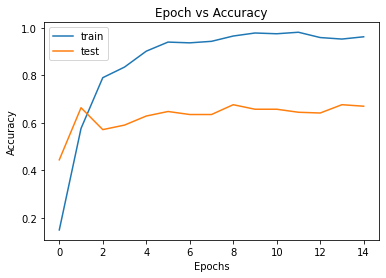

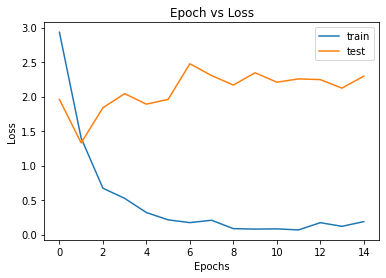


Classification Report

                  precision    recall  f1-score   support

      swipe left       0.83      1.00      0.91        15
     swipe right       0.93      0.87      0.90        15
            wave       0.61      0.73      0.67        15
            clap       0.76      0.87      0.81        15
           throw       0.43      0.20      0.27        15
       arm cross       1.00      0.87      0.93        15
basketball shoot       0.43      0.60      0.50        15
          draw x       0.85      0.73      0.79        15
  draw circle CW       0.86      0.40      0.55        15
 draw circle CCW       1.00      0.47      0.64        15
   draw triangle       0.76      0.87      0.81        15
         bowling       0.62      0.53      0.57        15
          boxing       1.00      0.07      0.12        15
  baseball swing       0.50      0.73      0.59        15
    tennis swing       0.38      0.53      0.44        15
        arm curl       0.94      1.00      0.97

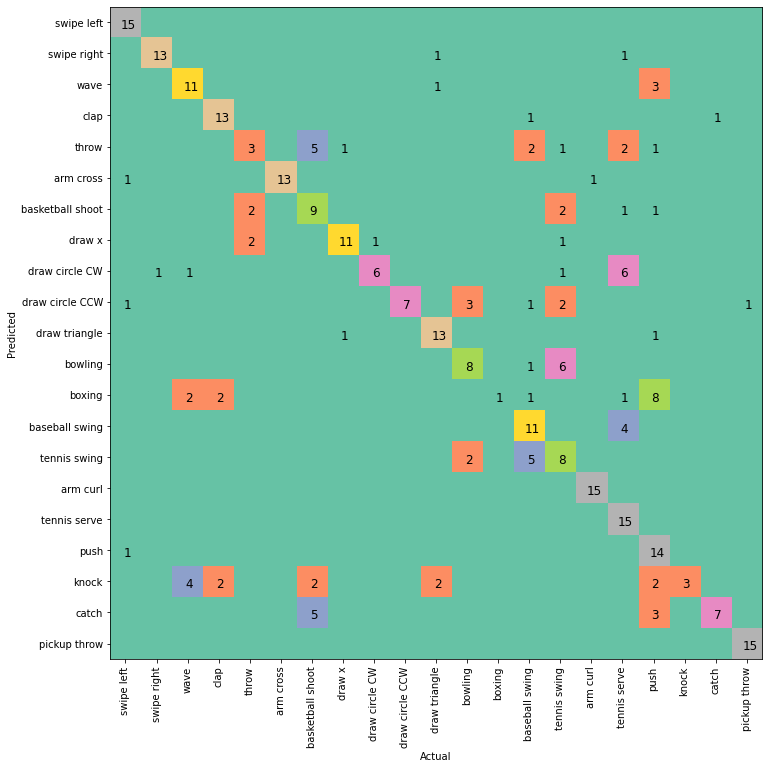

In [40]:
np.random.seed(0)
model_comb = models.Sequential(name = 'CNN_and_LSTM')
model_comb.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_comb.add(BatchNormalization())
model_comb.add(layers.MaxPooling3D((2, 2, 2)))
model_comb.add(Dropout(0.5))
model_comb.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_comb.add(layers.Conv3D(20, (3, 3, 2), activation='selu'))
model_comb.add(Dropout(0.5))
model_comb.add(layers.Conv3D(10, (4, 4, 2), activation='selu'))
model_comb.add(layers.TimeDistributed(Flatten()))
#TimeDistributed(Flatten())
model_comb.add(Bidirectional(CuDNNLSTM(512)))
model_comb.add(Dropout(0.5))
#model.add(layers.Dense(2100, activation='selu'))
#model.add(Dropout(0.5))
model_comb.add(layers.Dense(2100, activation='tanh'))
model_comb.add(layers.Dense(21, activation='softmax'))
print(model_comb.summary())


model_comb.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)
weights_dir = 'weights/' + model_comb.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_comb.fit(X_all_img_train, Y_train , epochs=15, 
                    batch_size=32, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[7,:]=calc_scores(history)
conf_mat(X_all_img_test, Y_test, model_comb)

In [41]:
import pandas as pd
row_names=["CNN simple","LSTM simple","Bidirectional LSTM","MTF image CNN"
           ,"GAF image CNN","RP image CNN","MTF+GAF+RP image CNN","CNN+LSTM"]
column_names=["Training Accuracy %","Test Accuracy %"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results

,Training Accuracy %,Test Accuracy %
CNN simple,74.203819,62.857145
LSTM simple,73.885351,38.730159
Bidirectional LSTM,100.000000,77.142859
MTF image CNN,98.089170,64.126986
GAF image CNN,98.407644,76.190478
RP image CNN,99.363059,46.349207
MTF+GAF+RP image CNN,100.000000,75.555557
CNN+LSTM,96.178347,66.984129
